In [42]:
# total usable memory in mega bytes
torch.cuda.get_device_properties(0).total_memory / 1024 / 1024

11264.0

In [43]:
import __future__
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipdb import set_trace
from IPython.display import HTML

manualSeed = 999
print('Random Seed: ', manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [44]:
dataroot = './'
workers = 2
batch_size = 128
image_size = 64
# number of channels in train images
nc = 3
# size of z latent vector
nz = 100
# size of feature maps in G
ngf = 64
# size of feature maps in D
ndf = 64
num_epochs = 5
lr = 0.0002
#hyper param for Adam
beta1 = 0.5
ngpu = 1

### Dataset

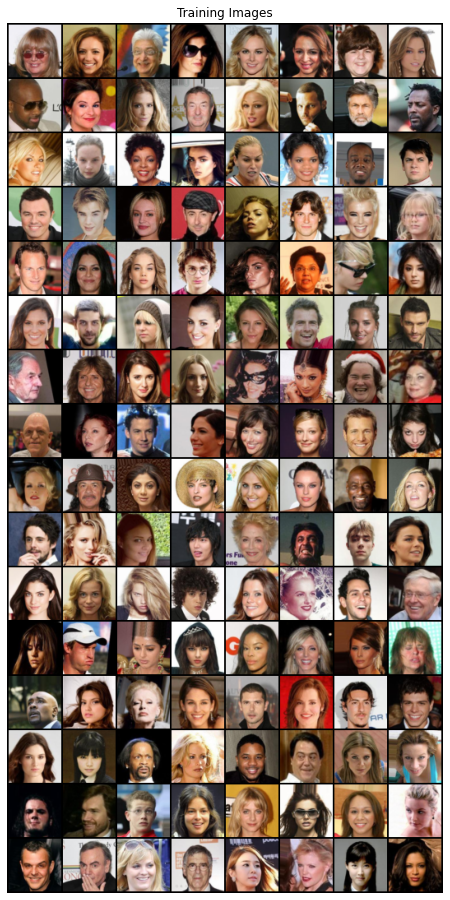

In [45]:
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size), transforms.CenterCrop(image_size),
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,\
    num_workers=workers)
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2,\
    normalize=True).cpu(), (1, 2, 0)))

### weights

In [46]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


### models 


In [47]:
class G(nn.Module):
    def __init__(self, ngpu):
        super(G, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # conv1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # conv2 
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # conv3
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # conv4
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # conv5
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

class D(nn.Module):
    def __init__(self, ngpu):
        super(D, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # conv1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # conv2
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # conv3
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # conv4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # conv5
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )
    def forward(self, input):
        return self.main(input)

### build models

In [48]:
netG = G(ngpu).to(device)
netD = D(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))
netG.apply(weights_init)
netD.apply(weights_init)



D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### loss, optimizers

In [49]:
criterion = nn.BCELoss()
fixed_noise = torch.rand(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))



In [55]:
img_list = []
G_losses = []
D_losses = []
iters = 0
os.mkdir('./checkpoints')

print('Starting Training')
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ##########################
        # update D: maxmize log(D(x)) + log(1 - D(G(z)))
        ##########################
        netD.zero_grad()
        # format batch
        real_cpu = data[0].to(device=device)
        b_size = real_cpu.size(0)
        label = torch.tensor(data[1].numpy(), dtype=torch.float, device=device)
        # train with real batch
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # train with fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimD.step()

        ##########################
        # update G: maxmize log(D(G(z)))
        ##########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x):\
                %.4f\tD(G(z)): %.4f / %.4f' % (epoch, num_epochs, i, len(dataloader),\
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        if i == len(dataloader) - 1 or i and i % 1000 == 0 :
            # visualize the generator's result
            plt.figure(figsize=(8, 8))
            plt.axis('off')
            plt.title('Training Images')
            plt.imshow(np.transpose(vutils.make_grid(fake[:10].detach(), padding=1,\
                normalize=True).cpu(), (1, 2, 0)))
            plt.show()
            # print memory usage
            print(torch.cuda.memory_summary())
            # save models
            torch.save(netD.state_dict, f'./checkpoints/D_{epoch}_{i}.pth')
            torch.save(netG.state_dict, f'./checkpoints/G_{epoch}_{i}.pth')


Starting Training
[0/5][0/1583]	Loss_D: 2.5828	Loss_G: 6.0697	D(x):                0.9822	D(G(z)): 0.8877 / 0.0046
[0/5][100/1583]	Loss_D: 1.4663	Loss_G: 0.8951	D(x):                0.3175	D(G(z)): 0.0288 / 0.4764
[0/5][200/1583]	Loss_D: 0.8749	Loss_G: 1.0429	D(x):                0.5114	D(G(z)): 0.0884 / 0.4125
[0/5][300/1583]	Loss_D: 1.0064	Loss_G: 1.8204	D(x):                0.4631	D(G(z)): 0.0695 / 0.2300
[0/5][400/1583]	Loss_D: 0.5568	Loss_G: 2.5133	D(x):                0.7799	D(G(z)): 0.2219 / 0.1139
[0/5][500/1583]	Loss_D: 0.8370	Loss_G: 1.8519	D(x):                0.5897	D(G(z)): 0.1789 / 0.2103
[0/5][600/1583]	Loss_D: 0.5373	Loss_G: 2.4474	D(x):                0.7171	D(G(z)): 0.1371 / 0.1144
[0/5][700/1583]	Loss_D: 0.5506	Loss_G: 1.8494	D(x):                0.6714	D(G(z)): 0.1034 / 0.1923
[0/5][800/1583]	Loss_D: 0.6133	Loss_G: 1.4973	D(x):                0.6320	D(G(z)): 0.0851 / 0.2695
[0/5][900/1583]	Loss_D: 0.7724	Loss_G: 2.2956	D(x):                0.6963	D(G(z)): 0.2724 / 0

KeyboardInterrupt: 

In [20]:
%debug

> c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\conv.py(415)_conv_forward()
    413                             weight, self.bias, self.stride,
    414                             _pair(0), self.dilation, self.groups)
--> 415         return F.conv2d(input, weight, self.bias, self.stride,
    416                         self.padding, self.dilation, self.groups)
    417 



In [ ]:
]